In [1]:
import numpy as np
import scipy.stats
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

plt.rcParams['figure.figsize'] = [13, 5]

from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
omega = 1.0
rho = 0.05
tau = 0.5
beta = 0.27
T = 15
xi = 1/np.sqrt(rho)

initial_dist = scipy.stats.norm(np.power(2, -0.5), 0.5)
phi = lambda x: beta*np.sign(x);
# phi = lambda x: np.zeros_like(x)

# Discretization
# If you keep Nt low, there will be huge steps between t to t+1 which causes ringin artifacts.
Nx = 150
Nt = 1000

xs = np.linspace(-6, 6, Nx)
dx = xs[1] - xs[0]
ts = np.linspace(0, T, Nt)
dt = ts[1] - ts[0]

In [3]:
def calculate_gamma(x, xi, qt, rt):
    y = tau*omega*qt*xi - phi(x)
    y = y - x*(tau*omega*np.square(qt) - rt + 0.5*np.square(tau)*(1+omega*np.square(qt)))
    return y

def calculate_q(Pt, xs):
    return np.sqrt(rho)*np.dot(Pt[1], xs)*dx

def calculate_r(Pt, xs):
    px = phi(xs)
    
    # xi = 0
    y1 = (1-rho) * np.dot(xs*px, Pt[0])*dx
    # xi > 0
    y2 = rho * np.dot(xs*px, Pt[1])*dx
    
    return y1 + y2

def d_central(fun, dx, order):
    kernels = {
        1: np.array([-0.5, 0, 0.5]) / dx,
        2: np.array([1, -2, 1]) / np.square(dx),
    }
    
    kernel = kernels[order]
    return np.correlate(np.pad(fun, (1, 1)), kernel, mode='valid')

def get_new_P(P, gp, qt):
    dgp = d_central(gp*P, dx, 1)
    ddp = 0.5*np.square(tau)*(1 + omega*np.square(qt))*d_central(P, dx, 2)
    return P + (-dgp + ddp)*dt

In [10]:
P_all = np.zeros((2, Nt, Nx))
ddP = np.zeros((Nt, Nx))
Gamma = np.zeros((Nt, Nx))
dP = np.zeros((Nt, Nx))
dPdt = np.zeros((Nt, Nx))

Q = np.zeros(Nt)
R = np.zeros(Nt)

# P_all[0] is for xi=0
# P_all[1] is for xi>0

P_all[0, 0, :] = initial_dist.pdf(xs)
P_all[1, 0, :]= initial_dist.pdf(xs)

Q[0] = calculate_q(P_all[:, 0], xs)
R[0] = calculate_r(P_all[:, 0], xs)

for t in range(0,Nt-1):
    Pt = P_all[:, t, :]

    qt = calculate_q(Pt, xs)
    rt = calculate_r(Pt, xs)
        
    gp1 = calculate_gamma(xs, 0, qt, rt)
    gp2 = calculate_gamma(xs, xi, qt, rt)
    
    P_all[0, t+1] = get_new_P(Pt[0], gp1, qt)
    P_all[1, t+1] = get_new_P(Pt[1], gp2, qt)
    
    Q[t+1] = qt
    R[t+1] = rt

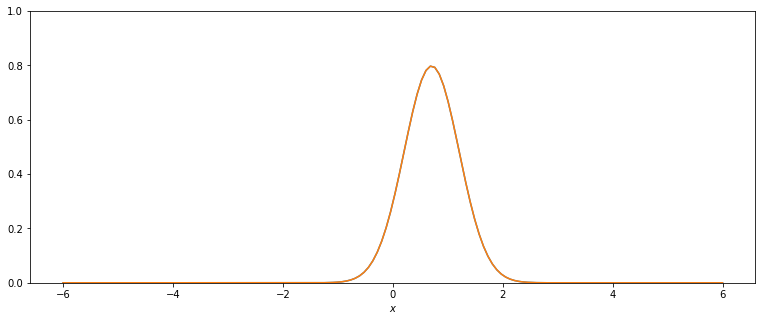

In [7]:
def plot_p(t=0):
    plt.plot(xs, P_all[:, t, ].T)
    plt.ylim((0, 1))
    
    plt.xlabel("$x$")

t_slider = widgets.IntSlider(min=0, max=Nt-1, step=1, value=0)
interact(plot_p, t=t_slider);

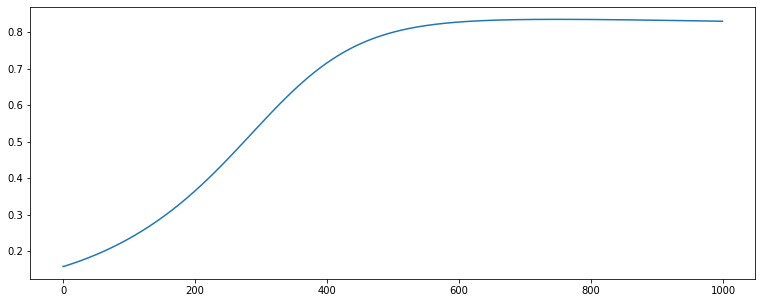

In [6]:
plt.plot(Q)

In [13]:
Q[-1], R[-1]

(0.8302330436298156, 0.15036968335473197)

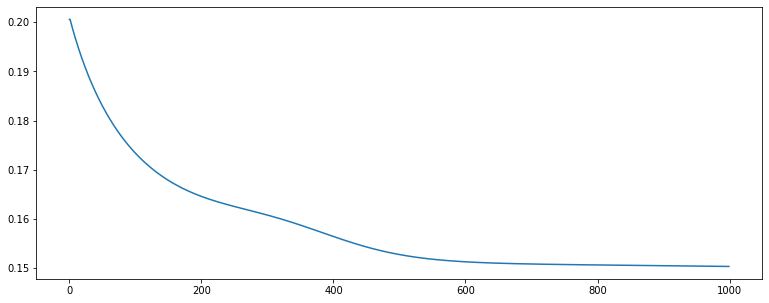

In [11]:
plt.plot(R)

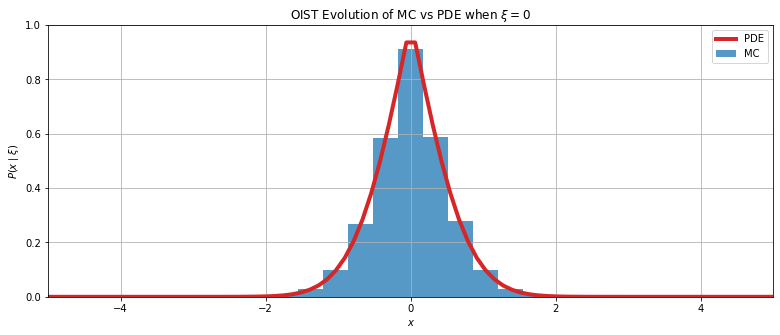

In [74]:
# Animate the PDE

component = 0
fig, ax = plt.subplots()
bins = np.linspace(-5, 5, 30)

def animate(i):
    plt.cla()
    ax.plot(xs, P_all[component, i], lw=4, label='PDE', c='C3')
    ax.hist(X_zeros[:, i] if component == 0 else X_sparse[:, i], density=True, bins=bins, label='MC',
           color='C0', alpha=0.75, lw=2)
    ax.set_xlim((-5, 5))
    ax.set_ylim((0, 1))
    ax.grid()
    
    ax.set_xlabel("$x$")
    ax.set_ylabel(r'''$P(x \mid \xi)$''')
    ax.set_title(fr'''OIST Evolution of MC vs PDE when $\xi={0 if component==0 else round(xi, 2)}$''')
    ax.legend()
    
    return []

anim = animation.FuncAnimation(fig, animate, frames=Nt, interval=10, blit=True)
HTML(anim.to_html5_video())

In [71]:
import h5py

f_oja = h5py.File("../data/oist_mc.jld", "r")

x_oja = f_oja['X_mc'].value
x_oja = np.swapaxes(x_oja, 1, 2)

# Only get the related time steps
p, _, n_iter = x_oja.shape
x_oja = x_oja[:, :, np.linspace(0, n_iter-1, Nt, dtype=int)]

Xi_oja = f_oja['Xi_mc'].value
Q_oja = f_oja['Q_mc'].value

/Users/cem/Documents/Migraine/denoise/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """
/Users/cem/Documents/Migraine/denoise/venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if sys.path[0] == '':
/Users/cem/Documents/Migraine/denoise/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  del sys.path[0]


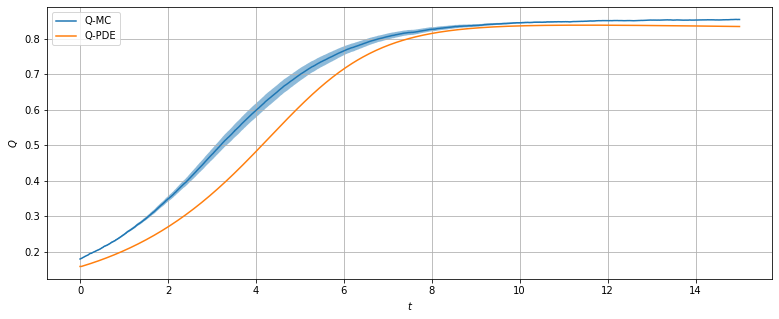

In [75]:
ts_mc = np.linspace(0, 15, Q_oja.shape[0])
Q_mean = Q_oja.mean(axis=1)
Q_var = Q_oja.var(axis=1)

plt.plot(ts_mc, Q_oja.mean(axis=1), label='Q-MC')
plt.fill_between(ts_mc, Q_mean+Q_var, Q_mean-Q_var, alpha=0.5)
plt.plot(ts, Q, label='Q-PDE')
plt.xlabel('$t$')
plt.ylabel('$Q$')
plt.legend()
plt.grid();

In [72]:
zero_idxs = np.where(Xi_oja == 0)
sparse_idxs = np.where(Xi_oja > 0)

X_zeros = x_oja[Xi_oja == 0, :]
X_sparse = x_oja[Xi_oja > 0, :]